### 1. Binance API Data Fetching


In [11]:
# Cell 1: Install dependencies (run once)
%pip install ta pandas matplotlib python-binance


In [13]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator  
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator

client = Client()

# Fetch data
bnb_data = client.get_historical_klines(
    symbol="BNBUSDT",
    interval=Client.KLINE_INTERVAL_1DAY,
    start_str="2024-01-01"
)

# Convert to DataFrame with proper typing
columns = [
    'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close Time', 'Quote Volume', 'Trades', 'TB Base Volume',
    'TB Quote Volume', 'Ignore'
]

df = pd.DataFrame(bnb_data, columns=columns)

# Convert numeric columns from string to float
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Volume']
df[numeric_cols] = df[numeric_cols].astype(float)

# Convert timestamps
df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

# Verify
print(df.dtypes)

Open Time          datetime64[ns]
Open                      float64
High                      float64
Low                       float64
Close                     float64
Volume                    float64
Close Time         datetime64[ns]
Quote Volume              float64
Trades                      int64
TB Base Volume             object
TB Quote Volume            object
Ignore                     object
dtype: object


### 2. Advanced Metrics (Showcasing Competence)

In [14]:
# Calculate volatility safely
try:
    df['Daily Volatility'] = ((df['High'] - df['Low']) / df['Low']) * 100
except Exception as e:
    print(f"Volatility calculation error: {e}")
    df['Daily Volatility'] = None  # Fallback

# Volume-Weighted Average Price (VWAP)
try:
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
except:
    df['VWAP'] = None
    
df['RSI'] = RSIIndicator(close=df['Close'], window=14).rsi()

# On-Balance Volume (OBV)
df['OBV'] = OnBalanceVolumeIndicator(
    close=df['Close'],
    volume=df['Volume']
).on_balance_volume()

# Calculate Bollinger Bands (20-day window, 2 std dev)
bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
df['BB_upper'] = bb.bollinger_hband()  # Upper band
df['BB_middle'] = bb.bollinger_mavg()  # Middle line (SMA)
df['BB_lower'] = bb.bollinger_lband()  # Lower band



# Save cleaned data
df.to_csv('../data/processed/bnb_cleaned.csv', index=False)

### 3. Visualizations (Matplotlib/Seaborn)

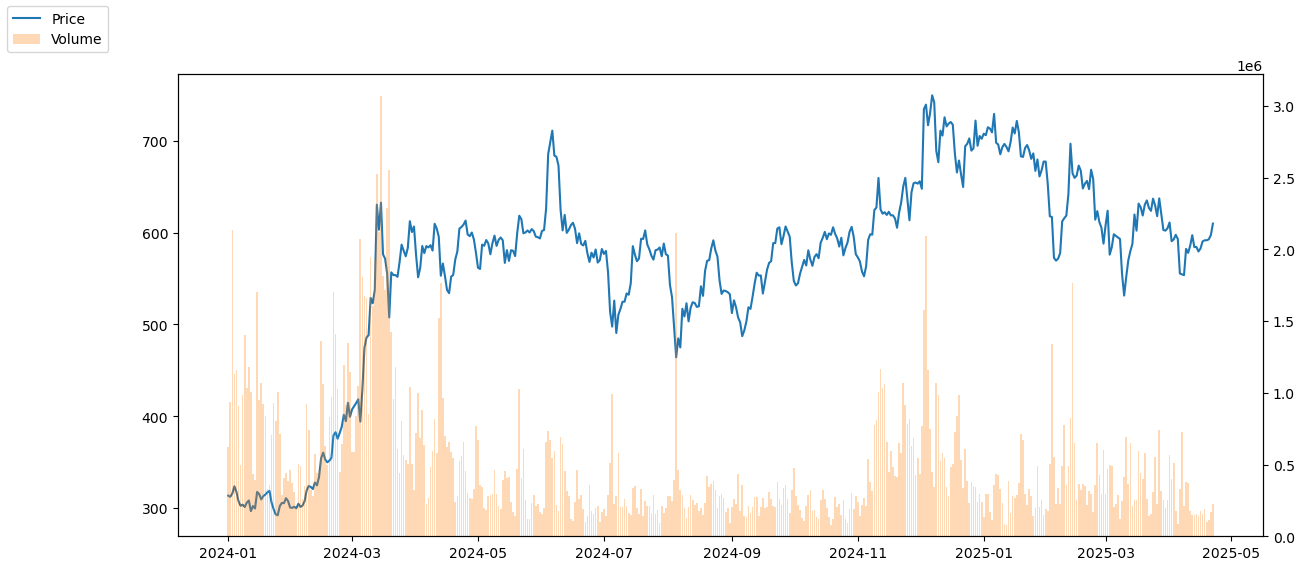

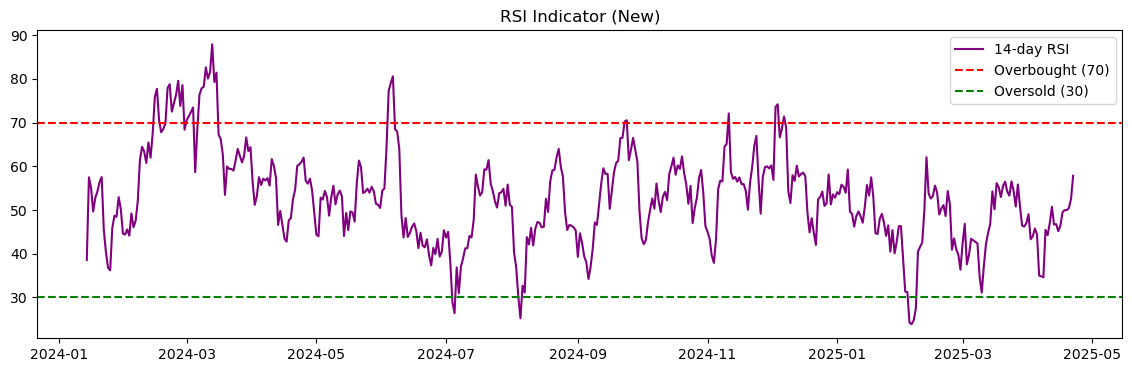

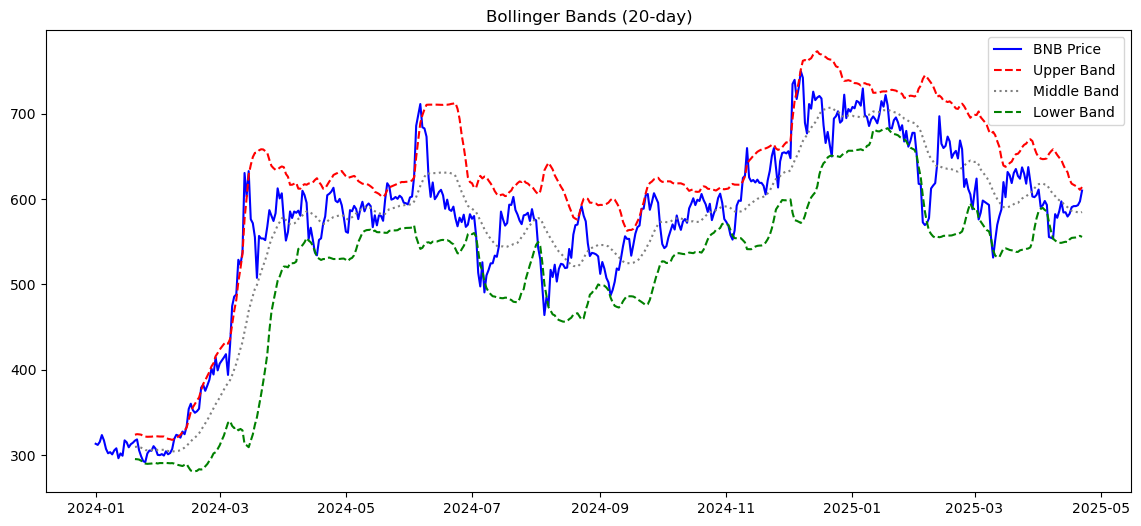

In [15]:
import matplotlib.pyplot as plt

# Dual-axis Price vs. Volume
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df['Open Time'], df['Close'], color='tab:blue', label='Price')
ax2 = ax1.twinx()
ax2.bar(df['Open Time'], df['Volume'], color='tab:orange', alpha=0.3, label='Volume')
fig.legend(loc='upper left')
plt.savefig('../data/processed/price_volume.png', dpi=300)

plt.figure(figsize=(14, 4))
plt.plot(df['Open Time'], df['RSI'], color='purple', label='14-day RSI')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator (New)')
plt.legend()
plt.savefig('rsi.png', dpi=300)

# Optional: Visualize Bollinger Bands
plt.figure(figsize=(14, 6))
plt.plot(df['Open Time'], df['Close'], label='BNB Price', color='blue')
plt.plot(df['Open Time'], df['BB_upper'], label='Upper Band', linestyle='--', color='red')
plt.plot(df['Open Time'], df['BB_middle'], label='Middle Band', linestyle=':', color='grey')
plt.plot(df['Open Time'], df['BB_lower'], label='Lower Band', linestyle='--', color='green')
plt.title('Bollinger Bands (20-day)')
plt.legend()
plt.savefig('bollinger_bands.png', dpi=300)

In [17]:

# Mock SQL Query (Binance-style Analytics)
sql_query = """
-- Binance Trading Analytics: Daily Summary
SELECT 
    DATE(open_time) AS trade_date,  -- Binance timestamps are in milliseconds
    SUM(volume) AS daily_volume,
    AVG(close) AS avg_price,
    MAX(high) AS daily_high,
    MIN(low) AS daily_low,
    COUNT(*) AS total_trades
FROM binance.klines  -- Binance's internal table for OHLCV data
WHERE 
    symbol = 'BNBUSDT' 
    AND open_time >= '2024-01-01'
GROUP BY trade_date
ORDER BY trade_date DESC
"""

# Optional: Convert your DataFrame to mimic SQL results (for practice)
# ---- Corrected Code (fixes the SyntaxError) ---- #
sql_results = df.groupby(pd.to_datetime(df['Open Time'])).agg({  # <-- Added missing ')'
    'Volume': 'sum',
    'Close': ['mean', 'max', 'min'],
    'Trades': 'count'
}).rename(columns={
    'mean': 'avg_price',
    'max': 'daily_high',
    'min': 'daily_low',
    'count': 'total_trades'
})

# Print the results
print("Daily Summary (SQL-like Output):")
print(sql_results.head())

Daily Summary (SQL-like Output):
                 Volume     Close                            Trades
                    sum avg_price daily_high daily_low total_trades
Open Time                                                          
2024-01-01   619455.158     313.5      313.5     313.5            1
2024-01-02   937764.737     312.2      312.2     312.2            1
2024-01-03  2132158.122     315.8      315.8     315.8            1
2024-01-04  1133774.957     323.7      323.7     323.7            1
2024-01-05  1157056.276     317.5      317.5     317.5            1
